<a href="https://colab.research.google.com/github/peterchang0414/hmm-jax/blob/main/fixed_lag_smoother.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fixed Lag Smoother

This notebook achieves the following: 

1. implements JAXified versions of fixed lag smoother;

2. demonstrates the correctness of the implementations by comparison of their full-lag smoothed posteriors with the results of JSL's implementation of `hmm_forwards_backwards_jax`;

3. demonstrates the improved "online" performance of a version that uses a vectorized approach to compute the $\beta$ values across its sliding window against the one that iteratively smooths backwards inside the window, as implemented in Kevin Murphy's HMM Toolbox for Matlab. 

The JAX State-Space Models Library (JSL) is available at:
https://github.com/probml/JSL

Kevin Murphy's Hidden Markov Model (HMM) Toolbox for Matlab is available at:
https://www.cs.ubc.ca/~murphyk/Software/HMM/hmm.html

Author: Peter G. Chang ([@peterchang0414](https://github.com/peterchang0414))

# 0. Imports

In [1]:
!pip install -q flax

In [2]:
!git clone https://github.com/probml/JSL.git

fatal: destination path 'JSL' already exists and is not an empty directory.


In [3]:
import sys
sys.path.insert(0,'/content/JSL')
from jsl.hmm.hmm_lib import HMMJax, hmm_forwards_backwards_jax, normalize

In [4]:
from functools import partial

import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap
from jax import jit
from jax.random import PRNGKey, split, choice, uniform

First, a quick aside. The current JSL implementation of `normalize` does not work as expected when applied to a rectangular matrix with `axis=1`, as demonstrated by the error raised below:

In [5]:
A = jnp.array([[1, 2], [2, 3], [3, 4]])

_ = normalize(A, axis=0) # Works as expected
# _ = normalize(A, axis=1) # Raises "Incompatible shapes for broadcasting error"

The following implementation fixes the issue by adding `keepdims=True`.

In [6]:
def normalize(u, axis=0, eps=1e-15):
    u = jnp.where(u == 0, 0, jnp.where(u < eps, eps, u))
    c = u.sum(axis=axis, keepdims=True)
    c = jnp.where(c == 0, 1, c)
    return u / c, c

_ = normalize(A, axis=1)     # Works as expected

# 1. Fixed Lag Smoother - Two Implementations

In [7]:
# Naive (un-vectorized) version
@partial(jit, static_argnums=(1))
def fixed_lag_smoother_iterative(params, win_len, alpha_win, obs_seq_win, obs, act=None):
    '''
    Computes the smoothed posterior for each state in the lagged window of
    fixed size, win_len.

    Parameters
    ----------
    params      : HMMJax
        Hidden Markov Model (with action-dependent transition)

    win_len     : int
        Desired window length (>= 2)
    
    alpha_win   : array
        Alpha values for the most recent win_len steps, excluding current step
    
    obs_seq_win : array
        Observations for the most recent win_len steps, excluding current step
    
    obs         : int
        New observation for the current step
    
    act         : array
        (optional) Actions for the most recent win_len steps, including current step
    
    Returns
    -------
    * array(win_len, n_states)
        Updated alpha values
    
    * array(win_len)
        Updated observations for the past d steps
    
    * array(win_len, n_states)
        Smoothed posteriors for the past d steps
    '''
    if len(alpha_win.shape) < 2:
        alpha_win = jnp.expand_dims(alpha_win, axis=0)
    curr_len = alpha_win.shape[0]
    win_len = min(win_len, curr_len+1)
    assert win_len >= 2, "Must keep a window of length at least 2."

    trans_mat, obs_mat = params.trans_mat, params.obs_mat
    n_states, n_obs = obs_mat.shape
    
    # If trans_mat is independent of action, adjust shape
    if len(trans_mat.shape) < 3:
        trans_mat = jnp.expand_dims(trans_mat, axis=0)
        act = None
    if act is None:
        act = jnp.zeros(shape=(curr_len+1,), dtype=jnp.int8)

    # Shift window forward by 1
    if curr_len == win_len:
        alpha_win = alpha_win[1:]
        obs_seq_win = obs_seq_win[1:]
    new_alpha, _ = normalize(
        obs_mat[:, obs] * (alpha_win[-1][:, None] * trans_mat[act[-1]]).sum(axis=0)
    )
    alpha_win = jnp.concatenate((alpha_win, new_alpha[None, :]), axis=0)
    obs_seq_win = jnp.append(obs_seq_win, obs)

    # Smooth backwards inside the window
    beta_win = jnp.ones(shape=(win_len, n_states))
    gamma_win = jnp.array(alpha_win)
    for t in range(win_len-2, -1, -1):
        new_beta, _ = normalize(
            (beta_win[t+1,:] * obs_mat[:, obs_seq_win[t+1]] *
             trans_mat[act[t]]).sum(axis=1)
        )
        beta_win = beta_win.at[t, :].set(new_beta)

        new_gamma, _ = normalize(alpha_win[t, :]*beta_win[t, :])
        gamma_win = gamma_win.at[t, :].set(new_gamma)
    return alpha_win, obs_seq_win, beta_win, gamma_win

In [16]:
# Vectorized version
@partial(jit, static_argnums=(1))
def fixed_lag_smoother_vectorized(params, win_len, alpha_win, bmatrix_win, obs, act=None):
    '''
    Computes the smoothed posterior for each state in the lagged window of
    fixed size, win_len.

    Parameters
    ----------
    params      : HMMJax
        Hidden Markov Model (with action-dependent transition)
    
    win_len     : int
        Desired window length (>= 2)
    
    alpha_win   : array
        Alpha values for the most recent win_len steps, excluding current step
    
    bmatrix_win : array
        Beta transformations for the most recent win_len steps, excluding current step
    
    obs         : int
        New observation for the current step
    
    act         : array
        (optional) Actions for the most recent win_len steps, including current step
    
    Returns
    -------
    * array(win_len, n_states)
        Updated alpha values
    
    * array(win_len, n_states)
        Updated beta transformations
    
    * array(win_len, n_states)
        Smoothed posteriors for the past d steps
    '''
    if len(alpha_win.shape) < 2:
        alpha_win = jnp.expand_dims(alpha_win, axis=0)
    curr_len = alpha_win.shape[0]
    win_len = min(win_len, curr_len+1)
    assert win_len >= 2, "Must keep a window of length at least 2."

    trans_mat, obs_mat = params.trans_mat, params.obs_mat
    n_states, n_obs = obs_mat.shape
    
    # If trans_mat is independent of action, adjust shape
    if len(trans_mat.shape) < 3:
        trans_mat = jnp.expand_dims(trans_mat, axis=0)
        act = None
    if act is None:
        act = jnp.zeros(shape=(curr_len+1,), dtype=jnp.int8)

    # Shift window forward by 1
    if curr_len == win_len:
        alpha_win = alpha_win[1:]
        bmatrix_win = bmatrix_win[1:]
        
    # Perform one forward operation
    new_alpha, _ = normalize(
        obs_mat[:, obs] * (alpha_win[-1][:, None] * trans_mat[act[-1]]).sum(axis=0)
    )
    alpha_win = jnp.concatenate((alpha_win, new_alpha[None, :]))

    # Smooth inside the window in parallel
    def update_bmatrix(bmatrix):
        return (bmatrix @ trans_mat[act[-2]]) * obs_mat[:, obs]
    bmatrix_win = vmap(update_bmatrix)(bmatrix_win)
    bmatrix_win = jnp.concatenate((bmatrix_win, jnp.eye(n_states)[None, :]))
    
    # Compute beta values by row-summing bmatrices
    def get_beta(bmatrix):
        return normalize(bmatrix.sum(axis=1))[0]
    beta_win = vmap(get_beta)(bmatrix_win)
    
    # Compute posterior values
    gamma_win, _ = normalize(alpha_win * beta_win, axis=1)
    return alpha_win, bmatrix_win, gamma_win

# 2. Helper Functions

We define some helper functions to run the two implementations on any given dataset.

In [9]:
def get_fls_result_iterative(params, data, win_len, act=None):
    assert data.size > 2, "Complete observation set must be of size at least 2"
    prior, obs_mat = params.init_dist, params.obs_mat
    alpha, _ = normalize(prior * obs_mat[:, data[0]])
    obs_seq = jnp.array([data[0]])
    for obs in data[1:]:
        alpha, obs_seq, beta, gamma = fixed_lag_smoother_iterative(params, win_len, alpha, obs_seq, obs)
    return alpha, beta, gamma

def get_fls_result_vectorized(params, data, win_len, act=None):
    assert data.size > 2, "Complete observation set must be of size at least 2"
    prior, obs_mat = params.init_dist, params.obs_mat
    n_states = obs_mat.shape[0]
    alpha, _ = normalize(prior * obs_mat[:, data[0]])
    bmatrix = jnp.eye(n_states)[None, :]
    for obs in data[1:]:
        alpha, bmatrix, gamma = fixed_lag_smoother_vectorized(params, win_len, alpha, bmatrix, obs)
    return alpha, gamma

# 3. Correctness of Implementation

First, we randomly generate a Hidden Markov Model with state space of size 3, observation space of size 5.


In [12]:
num_states = 3
num_obs = 5
key = PRNGKey(0)

# Generate transition matrix
trans_mat = uniform(key, shape=(num_states, num_states))
trans_mat, _ = normalize(trans_mat, axis=1)
key, _ = split(key)

# Generate observation likelihood matrix
obs_mat = uniform(key, shape=(num_states, num_obs))
obs_mat, _ = normalize(obs_mat, axis=1)
key, _ = split(key)

# Generate uniform random prior
prior, _ = normalize(jnp.ones(num_states))

# Generate HMM
hmm = HMMJax(trans_mat=trans_mat, obs_mat=obs_mat, init_dist=prior)

Then, we randomly generate an observed dataset of size 20.

In [13]:
num_timesteps = 20

# Generate random data
data = choice(key, num_obs, shape=(num_timesteps,))

Now, we test correctness of the two implementations by comparison of their full-lag results with JSL's `hmm_forwards_backwards_jax` implementation.

In [14]:
_, _, gamma_fb, _ = hmm_forwards_backwards_jax(hmm, data)
*_, gamma_it = get_fls_result_iterative(hmm, data, win_len=data.size)
*_, gamma_vec = get_fls_result_vectorized(hmm, data, win_len=data.size)

In [15]:
assert jnp.allclose(gamma_fb, gamma_it) and jnp.allclose(gamma_fb, gamma_vec)

# 4. Timed Experiments

We compare the performance of the two implementations by timing them against different sizes of windows. We reuse the HMM from the previous section. We use total observation set of size 1000.


In [19]:
# Plot timed results against different window sizes
import numpy as np

key = PRNGKey(0)
num_timestep = 1000
window_grid = np.insert(np.arange(10, 81, 10), 0, 2)
data = choice(key, num_obs, shape=(num_timestep,))

it_times, vec_times = [], []
for window_size in window_grid:
    print("window of size ", window_size)
    it_time = %timeit -o get_fls_result_iterative(hmm, data, window_size)
    vec_time = %timeit -o get_fls_result_vectorized(hmm, data, window_size)
    it_times.append(it_time.best)
    vec_times.append(vec_time.best)

window of size  2
The slowest run took 51.57 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 21.6 ms per loop
The slowest run took 20.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 20.6 ms per loop
window of size  10
The slowest run took 243.44 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 26.6 ms per loop
The slowest run took 94.51 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 21.3 ms per loop
window of size  20
The slowest run took 632.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 35.5 ms per loop
The slowest run took 179.90 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 22.2 ms per loop
window of s

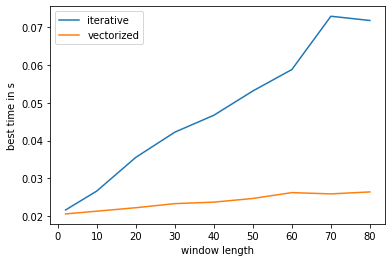

In [20]:
# Plot the result
plt.figure()
plt.plot(window_grid, it_times, label='iterative')
plt.plot(window_grid, vec_times, label='vectorized')
plt.xlabel('window length')
plt.ylabel('best time in s')
plt.legend();
plt.show()

Note that the speedup is even more pronounced if we remove jit from the equation by running each code once.

In [27]:
# Plot timed results against different window sizes - don't use cache
import time

window_grid = np.arange(2, 83, 10)

it_times, vec_times = [], []
for window_size in window_grid:
    print("window of size ", window_size)
    start = time.time()
    _ = get_fls_result_iterative(hmm, data, window_size)
    it_times.append(time.time()-start)
    start = time.time()
    _ = get_fls_result_vectorized(hmm, data, window_size)
    vec_times.append(time.time()-start)

window of size  2
window of size  12
window of size  22
window of size  32
window of size  42
window of size  52
window of size  62
window of size  72
window of size  82


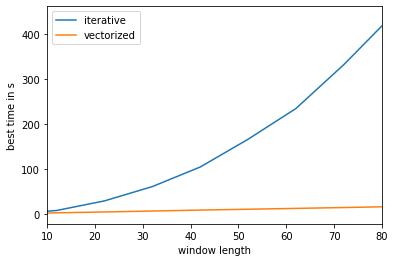

In [28]:
# Plot the result
plt.figure()
plt.plot(window_grid, it_times, label='iterative')
plt.plot(window_grid, vec_times, label='vectorized')
plt.xlabel('window length')
plt.ylabel('best time in s')
plt.xlim(10,80)
plt.legend();
plt.show()

In [170]:
# # Plot timed results against different observation set sizes

# %%capture
# key = PRNGKey(0)
# window_size = 10
# timestep_grid = jnp.arange(10, 500, 20)

# it_times, vec_times = [], []
# for timestep in timestep_grid:
#     print("timestep ", timestep)
#     data = choice(key, num_obs, shape=(timestep,))
#     key, _ = split(key)
#     it_time = %timeit -o get_fls_result_iterative(hmm, data, window_size)
#     vec_time = %timeit -o get_fls_result_vectorized(hmm, data, window_size)
#     it_times.append(1000*it_time.best)
#     vec_times.append(1000*vec_time.best)

# # Plot the result
# plt.figure()
# plt.plot(timestep_grid, it_times, label='iterative')
# plt.plot(timestep_grid, vec_times, label='vectorized')
# plt.xlabel('size of observation set')
# plt.ylabel('best time in ms')
# plt.legend();
# plt.show()